<div style="text-align: center;">

# Computational Foundations of Regression: Stability & Scalability

</div>

**Notebook:** `CDM__3.ipynb`

**Project Goal:** Evaluate numerical stability and computational scalability of regression solvers—specifically Normal Equations, SVD, BGD, and SGD—under conditions of collinearity and large datasets.

**Abstract:** This notebook investigates the trade-offs between analytical and iterative solutions for linear regression. It first uses synthetic data to demonstrate the instability of Normal Equations compared to SVD when features are collinear. It then analyzes the Auto MPG dataset to contrast the convergence properties of Batch Gradient Descent (BGD) versus Stochastic Gradient Descent (SGD). Finally, it implements Polynomial Regression using SGD to model non-linear relationships.

In [1]:
# -----------------------------------------------------------
# Import Libraries
# -----------------------------------------------------------

import numpy as np
import pandas as pd
import warnings
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Set seeds for reproducibility
np.random.seed(42)

warnings.filterwarnings("ignore")

In [2]:
# -----------------------------------------------------------
# Define Base Dataset (Small Data)
# -----------------------------------------------------------

# Matrix A: Design matrix [Bias, Feature 1]
A = np.array ([
    [1, 2.0],
    [1, 3.0],
    [1, 4.5],
    [1, 5.5]
])


# Vector y: Target values
y = np.array ([
    [3.1],
    [4.9],
    [8.2],
    [10.1]
])

m = len(y) # Number of samples

print(f"Matrix A shape: {A.shape}, Vector y shape: {y.shape}")

Matrix A shape: (4, 2), Vector y shape: (4, 1)


In [3]:
# -----------------------------------------------------------
# Solution via Normal Equations
# -----------------------------------------------------------

# Compute the inverse of (A_transpose * A) multiplied by (A_transpose * y)
theta = np.linalg.inv(A.T @ A) @ A.T @ y


print("Theta from normal equation:\n", theta)

Theta from normal equation:
 [[-1.04137931]
 [ 2.03103448]]


In [4]:
# -----------------------------------------------------------
# Solution via Batch Gradient Descent (BGD)
# -----------------------------------------------------------

theta_bgd = np.zeros((A.shape[1], 1)) # Initialize weights

learning_rate = 0.01
n_iterations = 1000

for _ in range(n_iterations):

    # Calculate gradient using the whole batch (A)
    gradients = (1 / m) * A.T @ (A @ theta_bgd - y)

    # Update weights
    theta_bgd = theta_bgd - learning_rate * gradients

print("Final theta from BGD:\n", theta_bgd)

Final theta from BGD:
 [[-0.55217831]
 [ 1.9146829 ]]


In [5]:
# -----------------------------------------------------------
# Solution via SVD (Pseudoinverse)
# -----------------------------------------------------------

# Decompose A into U, Sigma, and V_transpose
U, s, VT = np.linalg.svd(A, full_matrices=False)

# Invert Sigma (1/s) for non-zero singular values
s_inv = np.array([1/si if si > 1e-12 else 0 for si in s])

Sigma_plus = np.diag(s_inv)

# Compute Pseudoinverse A+
A_plus = VT.T @ Sigma_plus @ U.T

# Compute Theta
theta_svd = A_plus @ y

print("Final theta from SVD:\n", theta_svd)

Final theta from SVD:
 [[-1.04137931]
 [ 2.03103448]]


In [6]:
# -----------------------------------------------------------
# Create Collinear Data
# -----------------------------------------------------------

# Create noise and add a column almost identical to column 1
noise = np.random.rand(m, 1) * 1e-12

A_collinear = np.hstack((A, A[:, [1]] + noise))

In [7]:
print("Matrix A (Collinear):\n", A_collinear)

Matrix A (Collinear):
 [[1.  2.  2. ]
 [1.  3.  3. ]
 [1.  4.5 4.5]
 [1.  5.5 5.5]]


In [8]:
# -----------------------------------------------------------
# Normal Equations on Collinear Data
# -----------------------------------------------------------

# Note: This may produce unstable results due to singularity
ATA_col = A_collinear.T @ A_collinear

ATy_col = A_collinear.T @ y

theta_col_normal = np.linalg.inv(ATA_col) @ ATy_col

print("Theta from normal equations (Collinear):\n", theta_col_normal)

Theta from normal equations (Collinear):
 [[ 0.91293103]
 [ 5.084375  ]
 [-3.06757813]]


In [9]:
# -----------------------------------------------------------
# SVD on Collinear Data
# -----------------------------------------------------------

U, s, VT = np.linalg.svd(A_collinear, full_matrices=False)

# Handle singular values carefully
s_inv = np.array([1/si if si > 1e-12 else 0 for si in s])

Sigma_plus = np.diag(s_inv)

A_plus = VT.T @ Sigma_plus @ U.T

theta_col_svd = A_plus @ y

print("Final theta from SVD (Collinear):\n", theta_col_svd)

Final theta from SVD (Collinear):
 [[-1.04137931]
 [ 1.01551724]
 [ 1.01551724]]


In [10]:
# -----------------------------------------------------------
# Load and Clean Data
# -----------------------------------------------------------

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'

column_names = [
    'MPG', 'Cylinders', 'Displacement', 'Horsepower',
    'Weight', 'Acceleration', 'ModelYear', 'Origin', 'CarName'
]

# Load data, handling missing values represented by '?'
data_mpg = pd.read_csv(
    url,
    names=column_names,
    na_values='?',
    delim_whitespace=True
)

# Drop missing rows and convert type
data_mpg = data_mpg.dropna(subset=['Horsepower'])

data_mpg['Horsepower'] = data_mpg['Horsepower'].astype(float)

data_mpg.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear,Origin,CarName
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [11]:
# -----------------------------------------------------------
# Prepare Matrices & Feature Scaling
# -----------------------------------------------------------

# Feature: Horsepower, Target: MPG
X = data_mpg['Horsepower'].values.reshape(-1, 1)
y = data_mpg['MPG'].values.reshape(-1, 1)

# Normalize features for better convergence (Crucial for GD)
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

# Add Bias term (column of ones)
A = np.hstack([np.ones((X_norm.shape[0], 1)), X_norm])

m = len(y)

print("Shape of A:", A.shape)

print("Shape of y:", y.shape)

Shape of A: (392, 2)
Shape of y: (392, 1)


In [12]:
# -----------------------------------------------------------
# BGD Implementation & Cost Tracking
# -----------------------------------------------------------

def compute_cost(A, y, theta):
    residual = A @ theta - y

    return (residual.T @ residual) / (2 * m)

theta_bgd = np.zeros((A.shape[1], 1))
history_bgd = []

learning_rate = 0.01
n_iterations = 1000

for _ in range(n_iterations):

    # Update using FULL batch
    gradients = (1 / m) * A.T @ (A @ theta_bgd - y)

    theta_bgd = theta_bgd - learning_rate * gradients

    # Log cost
    history_bgd.append(compute_cost(A, y, theta_bgd))

print("Final theta from BGD:\n", theta_bgd)

Final theta from BGD:
 [[23.44490618]
 [-6.06761045]]


In [13]:
# -----------------------------------------------------------
# SGD Implementation
# -----------------------------------------------------------

def SGD(A, y, learning_rate=0.01, n_iterations=5000):
    m, n = A.shape

    theta = np.zeros((n,1))

    history = []

    for _ in range(n_iterations):
        # Pick random instance
        i = np.random.randint(0, m)     

        Ai = A[i:i+1, :]
        yi = y[i:i+1, :]

        # Update using ONE instance
        grad_i = Ai.T @ (Ai @ theta - yi)

        theta = theta - learning_rate * grad_i

        # Log global cost for comparison
        history.append(compute_cost(A, y, theta))

    return theta, history

theta_sgd, history_sgd = SGD(A, y, learning_rate=0.01, n_iterations=5000)

print("Final theta from SGD:\n", theta_sgd)

Final theta from SGD:
 [[22.5832758 ]
 [-6.51916008]]


In [14]:
# Flatten arrays for plotting
history_bgd = np.array(history_bgd).reshape(-1,)

history_sgd = np.array(history_sgd).reshape(-1,)

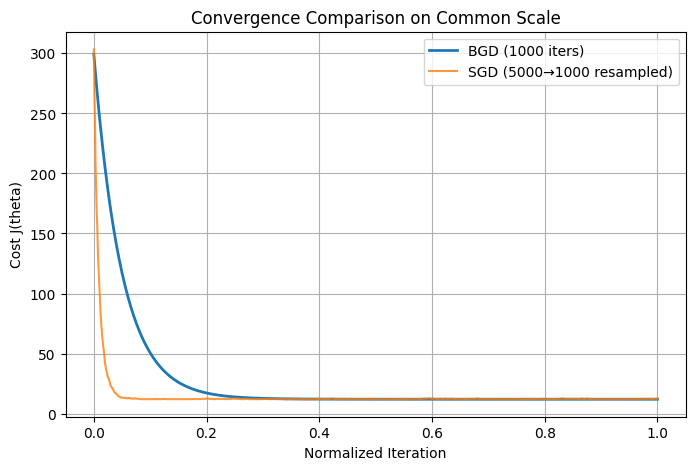

In [15]:
# -----------------------------------------------------------
# Plot Convergence Comparison (BGD vs SGD with Resampling)
# -----------------------------------------------------------

# Normalize iteration indices to the range [0, 1] for both algorithms.
# This allows us to compare them on a common scale even though
# they have different numbers of total iterations.
bgd_x = np.linspace(0, 1, len(history_bgd))
sgd_x = np.linspace(0, 1, len(history_sgd))

# Resample the SGD history to match the length of BGD using linear interpolation.
# This produces a 1-to-1 comparable curve showing the general convergence trend.
sgd_resampled = np.interp(bgd_x, sgd_x, history_sgd)

# Plot both learning curves on the normalized iteration axis.
plt.figure(figsize=(8,5))
plt.plot(bgd_x, history_bgd, label='BGD (1000 iters)', linewidth=2)
plt.plot(bgd_x, sgd_resampled, label='SGD (5000→1000 resampled)', alpha=0.8)

# Visualization labels and styling
plt.xlabel("Normalized Iteration")
plt.ylabel("Cost J(theta)")
plt.title("Convergence Comparison on Common Scale")
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# -----------------------------------------------------------
# Polynomial Feature Engineering
# -----------------------------------------------------------

# Create x^2 feature
x_poly = np.hstack([X, X**2])

# Normalize polynomial features
scaler_poly = StandardScaler()
x_poly_norm = scaler_poly.fit_transform(x_poly)

# Add bias term
Apoly = np.hstack([np.ones((x_poly_norm.shape[0], 1)), x_poly_norm])

print("Shape of Apoly:", Apoly.shape)

print("Shape of y:", y.shape)

Shape of Apoly: (392, 3)
Shape of y: (392, 1)


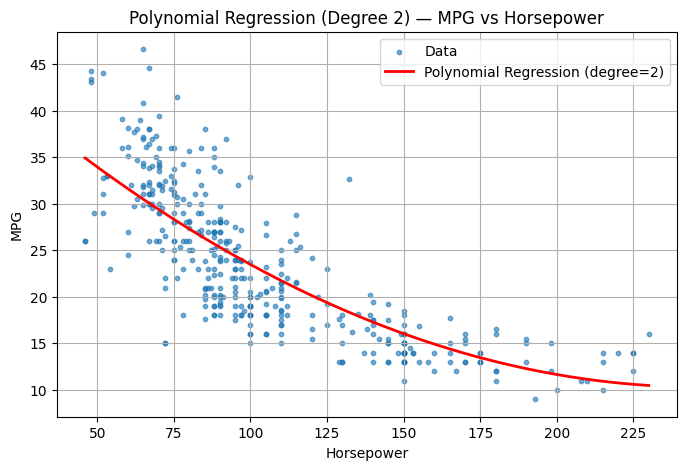

In [17]:
# -----------------------------------------------------------
# Train and Visualize Polynomial Model
# -----------------------------------------------------------

# 1. Generate prediction range for plotting line
x_plot = np.linspace(X.min(), X.max(), 300).reshape(-1,1)

# 2. Transform prediction range to polynomial features and scale
x_plot_poly = np.hstack([x_plot, x_plot**2])

x_plot_poly_norm = scaler_poly.transform(x_plot_poly)

A_plot = np.hstack([np.ones((x_plot_poly_norm.shape[0],1)), x_plot_poly_norm])

# 3. Train model using SGD (Efficient method)
theta_poly, hist_poly = SGD(Apoly, y, learning_rate=0.01, n_iterations=5000)

# 4. Predict values for curve
y_plot = A_plot @ theta_poly

# 5. Visualization
plt.figure(figsize=(8,5))
plt.scatter(X, y, s=10, alpha=0.6, label='Data')
plt.plot(x_plot, y_plot, color='red', linewidth=2, label='Polynomial Regression (degree=2)')
plt.xlabel("Horsepower")
plt.ylabel("MPG")
plt.title("Polynomial Regression (Degree 2) — MPG vs Horsepower")
plt.grid(True)
plt.legend()
plt.show()